# Performing surface adjustment for NUCAPS

Author: Rebekah Esmaili, Science and Technology Corportation, rebekah@stcnet.com

Description:

* [NUCAPS](https://weather.msfc.nasa.gov/nucaps/) satellite soundings retrieves temperature and trace gases in three dimensions. Suomi NPP and NOAA-20 NUCAPS data can be ordered from [CLASS](https://www.class.noaa.gov/).

* This Jupyter Notebook contains Python 3 code that will open the netCDF files and determine the **surface temperature** and **surface water vapor**. 
* Note that I am writing code to illustrate data use, and it is not optimized for speed nor does it follow "Pythonic" practices.

In this example, we'll use the following packages:

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

## Opening NUCAPS file and inspecting the contents

First, I import NUCAPS using the [xarray](http://xarray.pydata.org/en/stable/io.html). You can also use the netCDF4 package if you are more familiar with it than xarray.

In [2]:
data_dir = 'C:\\Users\\rebekah\\Dropbox\\STC\\Data_Files\\'
fname = 'NUCAPS-EDR_v2r0_npp_s201903031848390_e201903031849090_c201903031941100.nc'

nucaps = xr.open_dataset(data_dir + fname, decode_times=False)

Below I print out all of the available fields that we can access. 

In this example, I will use the following __dimensions__:

* Number_of_CrIS_FORs: This is the number if fields of regard (FOR) or footprints in the file. Footprints have a diameter of 50 (nadir) to 150 (scan edge) km. Each footprint contains a vertical profile of temperature, water vapor, and trace gases.
* Number_of_P_Levels: The number of pressure levels. This is always 100.

I will also use the following __Variables__:
* Pressure
* Effective_Pressure
* Surface Pressure
* Temperature
* H2O: The column density of water vapor at with 

Both Temperature and Water vapor have dimensions of 120 footprints (Number_of_CrIS_FORs in the netCDF file) and on the 100 level Pressure grid (Number_of_P_Levels), but temperature is measured on pressure levels (Pressure) while H2O is on pressure layers (Effective_Pressure).

In [3]:
print(nucaps)

<xarray.Dataset>
Dimensions:               (Number_of_Cloud_Emis_Hing_Pts: 100, Number_of_Cloud_Layers: 8, Number_of_CrIS_FORs: 120, Number_of_Ispares: 129, Number_of_MW_Spectral_Pts: 16, Number_of_P_Levels: 100, Number_of_Rspares: 262, Number_of_Stability_Parameters: 16, Number_of_Surf_Emis_Hinge_Pts: 100)
Coordinates:
    Time                  (Number_of_CrIS_FORs) float64 ...
    Latitude              (Number_of_CrIS_FORs) float32 ...
    Longitude             (Number_of_CrIS_FORs) float32 ...
    Pressure              (Number_of_CrIS_FORs, Number_of_P_Levels) float32 ...
    Effective_Pressure    (Number_of_CrIS_FORs, Number_of_P_Levels) float32 ...
Dimensions without coordinates: Number_of_Cloud_Emis_Hing_Pts, Number_of_Cloud_Layers, Number_of_CrIS_FORs, Number_of_Ispares, Number_of_MW_Spectral_Pts, Number_of_P_Levels, Number_of_Rspares, Number_of_Stability_Parameters, Number_of_Surf_Emis_Hinge_Pts
Data variables:
    quality_information   |S1 ...
    CrIS_FORs             (Number

## Finding surface temperature and H2O for one footprint

Below, I am using xarray to select just the first footprint (Number_of_CrIS_FORs=0) to illustrate the steps. This new, smaller dataset is saved to a variable called __footprint__.

In NUCAPS, temperature, water vapor, and trace gases are saved on a fixed grid that doesn't account for surface topography. Below, I am extracting the Pressure and Surface_Pressure variables for this single footprint:

In [4]:
footprint = nucaps.sel(Number_of_CrIS_FORs=0)

pres = footprint.Pressure.values
surfpres =  footprint.Surface_Pressure.values

Below, I have a plot below to show where the fixed grid levels are:

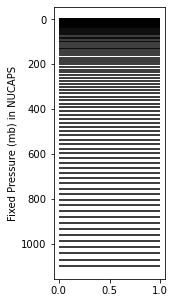

In [5]:
xmin = 0
xmax = 1

plt.figure(figsize=[2,5])
for i, y in enumerate(pres):
    plt.hlines(y, xmin, xmax, colors='k', linestyles='solid', label=str(i))

plt.ylabel("Fixed Pressure (mb) in NUCAPS")

ax1 = plt.gca() 
ax1.invert_yaxis()

plt.show()

The plot below to shows where the surface pressure is in comparison to the fixed grid values. For this footprint, the surface pressure is 1013.27 mb (dashed blue line), while the pressure value at the fixed level below and above (black lines) are 1013.95 mb and and 986.07 mb, respectively.

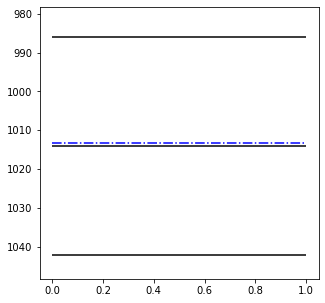

In [6]:
xmin = 0
xmax = 1

plt.figure(figsize=[5,5])
for i, y in enumerate(pres):
    plt.hlines(y, xmin, xmax, colors='k', linestyles='solid', label=str(i))
    
plt.hlines(surfpres, xmin, xmax, colors='b', linestyles='-.', label="Surface Pressure")
    
plt.ylim(surfpres-35, surfpres+35)
plt.gca().invert_yaxis()
plt.show()

I want an accurate measure of the surface temperature, water vapor, and trace gases. The bottom layer needs to be adjusted to account for the surface pressure instead of using the NUCAPS grid. The boundary layer multiplier (**blmult**)  quantifies the degree to which the bottom profile layer needs to be adjusted.
 
![](blmult_images\blmult.PNG)\[Eq. 1\]

We need to determine is the index of the pressure level that is closest to Psurf while always satisfying the condition:
 
![](blmult_images\psurf_condition.PNG)\[Eq. 2\]

This condition ensures that Plev(Pbot) is always less than Psurf by at least 5 hPa. Then to calculate surface temperature, which is preported on pressure levels, we can use:

![](blmult_images\T_surf.PNG)\[Eq. 3\]

For surface water vapor, which is a trace gas on a layer grid, we use:

![](blmult_images\tgas_surf.PNG)\[Eq. 4\]


Below, I have function (__find_surface__) that calculates where the conditions for Eq. 2 are met: 

* Condition 1: If the surface pressure is __less than__ the pressure at the closest point then surflev is __clev__
* Condition 2: If the surface pressure is __greater than__ than the pressure at the closest point AND also __greater or equal to__ than 5.0 mb, then surflev is __clev__
* Condition 3: If the surface pressure is __greater than__ than the pressure at the closest point AND also __greater than (and not equal to)__ 5.0 mb, then surflev is __clev+1__

In [7]:
def find_surface(pres, surfpres):
    # Find the index of where pressure is closest to the surface pressure:
    diff = np.abs((pres - surfpres))
    mindiff = np.min(diff)
    clev = np.where(diff == mindiff)[0][0]
    
    surflev = clev
    # Condition 1
    if surfpres < pres[clev]:
        surflev = clev
        
    # Condition 2
    elif surfpres > pres[clev] and mindiff >= 5.0:
        surflev = clev
    
    # Condition 3
    elif surfpres > pres[clev] and mindiff > 5.0:
        surflev = clev + 1
        
    return surflev

Now that we know the surface level we can calculate **blmult** (Eq. 2)

In [8]:
def calc_blmult(pres, surfpres, surflev):
    num = surfpres - pres[surflev - 1]
    denom = pres[surflev] - pres[surflev - 1]
    blmult = num / denom
    
    return blmult

As an example, let's try these two functions out for the first footprint. Running the code below, the **surflev** value is 96. In this example, the surface pressure < pres\[clev\] (triggering the if statement commands from condition 1)

In [9]:
surflev = find_surface(pres, surfpres)
print(surflev)

96


Running the code below, the blmult value is ~0.98 for this footprint. Note that BLMult will only range betweem 0 and 1.

In [10]:
blmult = calc_blmult(pres, surfpres, surflev)
print(blmult)

0.9756262012863341


Now, I can use **blmult** and **surflev** to calculate the surface temperature (Eq. 3). Below, I extract all the vertical temperature values (which will have 100 values, one for each pressure level) into a variable called __temperature__. Then, I calculate the difference in the temperature (__t_diff__) above and below the surface pressure (using __surflev__ and __surflev-1__). __t_diff__ is adjusted by the **blmult** and added to the temperature on the top layer (__surflev - 1__) to get the surface temperature.

In [11]:
# Surface Temperature
temperature = footprint.Temperature.values

t_diff = temperature[surflev] - temperature[surflev - 1]
print(temperature[surflev - 1] + blmult * t_diff)

297.59265090488293


We can use blmult and surflev values to calculate the water vapor (Eq. 4), but because it is reported as a column density, this value is reported on pressure layers. I extract all the vertical H2O values into a variable called __water_cd__. Then, I adjust the bottom level (__surflev-1__) by the blmult to get the surface water vapor.

In [12]:
# Surface Water Vapor
water_cd = footprint.H2O.values
print(water_cd[surflev] * blmult)

1.2148502201440307e+22


## Automating the surface calculation over all footprints

We can consolidate the code above and create a loop over each footprint. As a reminder, there are 120 in the file and are indexed from 0 to 120 in the dimension **Number_of_CrIS_FORs** in the NUCAPS netCDF file. The steps inside the loop are similar to those above:

1. Extract the pressure and surface pressure to find the surface level (**surflev_0**).
2. Use the surface level to calculate BLMULT (**blmult_0**)
3. Calculate the surface temperature (**tsfc_0**)
4. Calculate the surface water vapor (**wsfc_0**)

To access these values after the loop completes, I am storing the single-valued **surflev_0, blmult_0, tsfc_0, wsfc_0** in lists, which respectively are **surflev, blmult, tsfc, wsfc**.

In [13]:
surflev = []
blmult = []
tsfc = []
wsfc = []

for fp in nucaps.Number_of_CrIS_FORs.values:
    # Extract the pressure and surface pressure for each footprint
    footprint = nucaps.sel(Number_of_CrIS_FORs=fp)
    pres = footprint.Pressure.values
    surfpres = footprint.Surface_Pressure.item()
    
    # Find the surface level and blmult
    surflev_0 = find_surface(pres, surfpres)
    blmult_0 = calc_blmult(pres, surfpres, surflev_0)
    
    # Calculate surface Temp.
    temperature = footprint.Temperature.values
    t_diff = temperature[surflev_0] - temperature[surflev_0 + 1]
    tsfc_0 = temperature[surflev_0 - 1] + blmult_0 * t_diff
    
    # Calculate surface WV
    water_cd = footprint.H2O.values
    wsfc_0 = water_cd[surflev_0] * blmult_0
    
    # Keep a list of the surface level, blmult, and sufrace Temp., WV
    surflev.append(surflev_0)
    blmult.append(blmult_0)
    tsfc.append(tsfc_0)
    wsfc.append(wsfc_0)